# Time Series Analysis on Air Passengres dataset

In [611]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
import plotly.graph_objects as go
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from scipy.special import inv_boxcox
from statsmodels.tsa.arima.model import ARIMA


In [200]:
df=pd.read_csv('C:/Anaconda3/time_series/AirPassengers.csv')
df['Date']=pd.to_datetime(df['Date'])
df.head()

Month  #Passengers
0 1949-01-01          112
1 1949-02-01          118
2 1949-03-01          132
3 1949-04-01          129
4 1949-05-01          121

In [202]:
df=df.rename(columns={'Date':'Date','Number_of_Passengers':'Number_of_Passengers'})
df.head()

Date  Number_of_Passengers
0 1949-01-01                   112
1 1949-02-01                   118
2 1949-03-01                   132
3 1949-04-01                   129
4 1949-05-01                   121

In [204]:
df_original=df.copy()

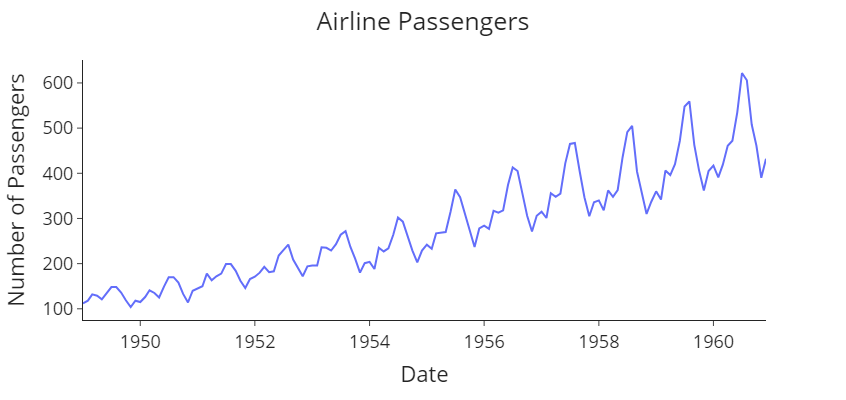

In [206]:
# Define the Plotly function
def plotting( data, x, y, title, x_label, y_label):
    fig = px.line(data, x=x, y=y, labels={x: x_label, y: y_label})
    
    fig.update_layout(template="simple_white", font=dict(size=18),
                      title_text=title, width=650,
                      title_x=0.5, height=400)

    fig.show()

# Use the Plotly plotting function for an interactive plot
plotting(df, 'Date', 'Number_of_Passengers', title='Airline Passengers', 
         x_label='Date', y_label='Number of Passengers')


### We want to know each Time Series Component

In [209]:
df.head()

Date  Number_of_Passengers
0 1949-01-01                   112
1 1949-02-01                   118
2 1949-03-01                   132
3 1949-04-01                   129
4 1949-05-01                   121

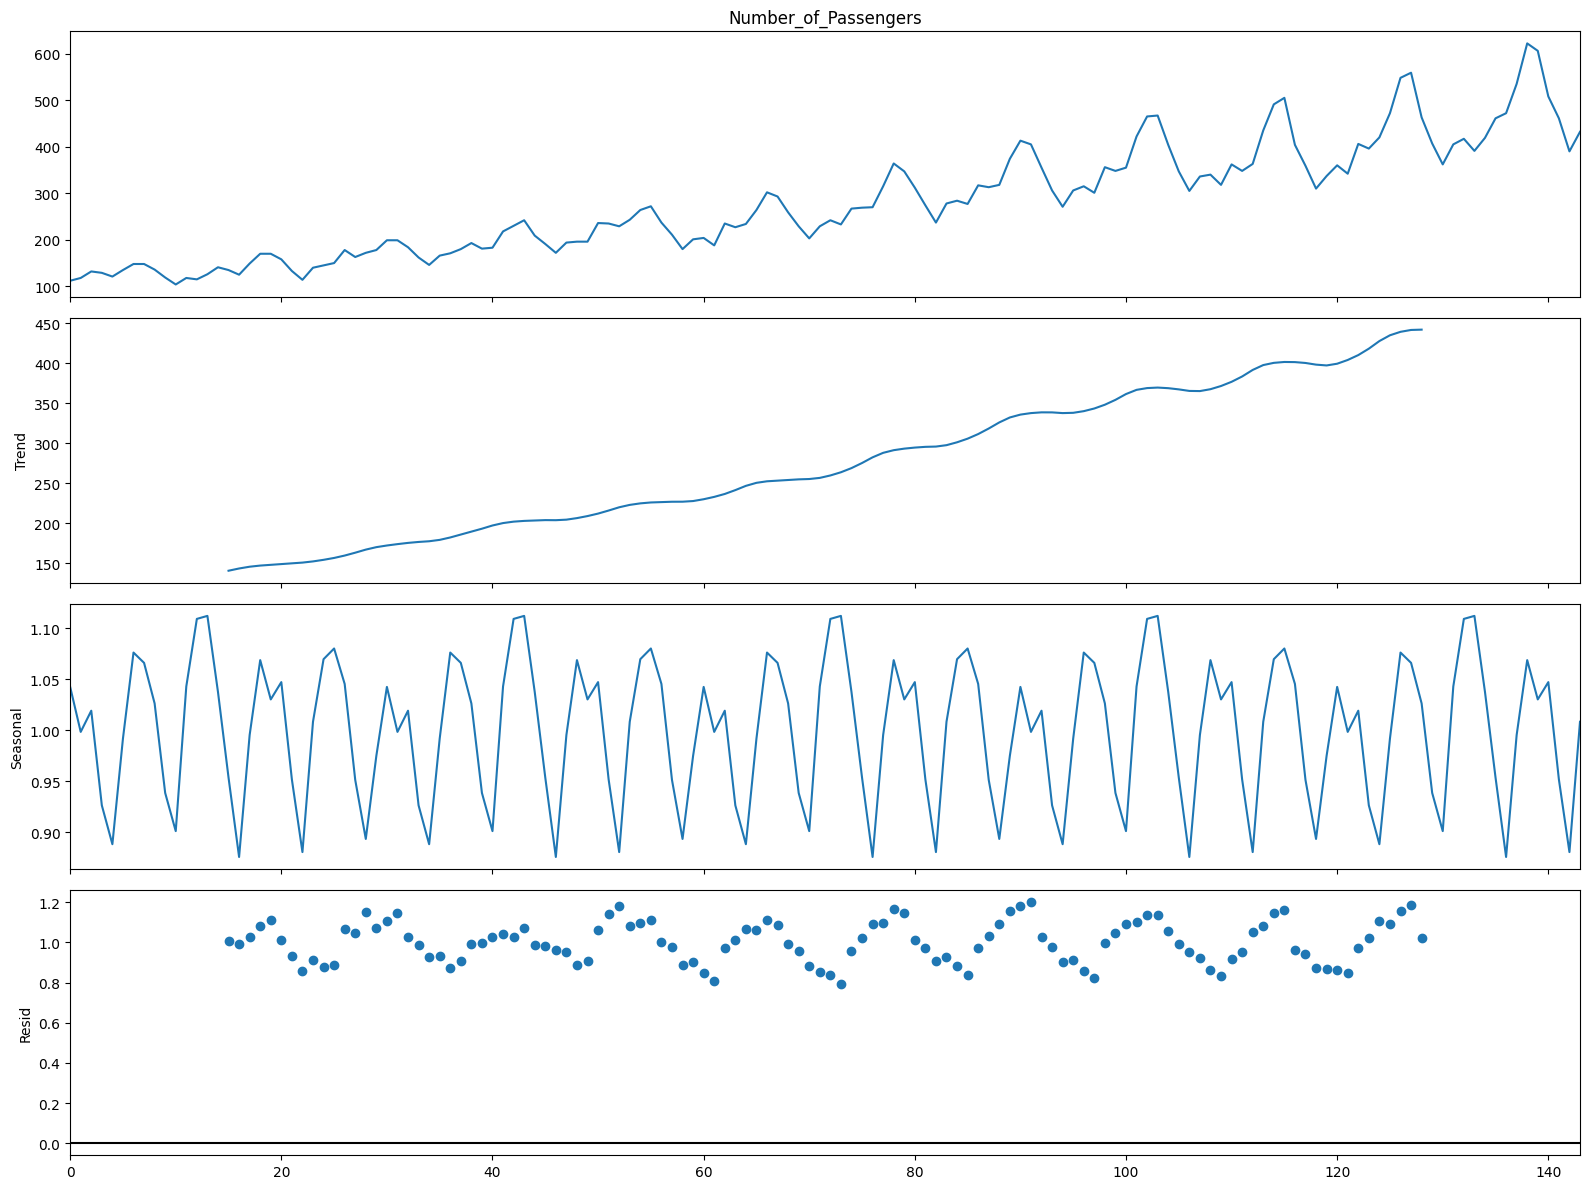

In [211]:
decomposition_plot_multi = seasonal_decompose(df['Number_of_Passengers'],
                                              model='multiplicative',period=30)
decomposition_plot_multi.plot()
plt.show()

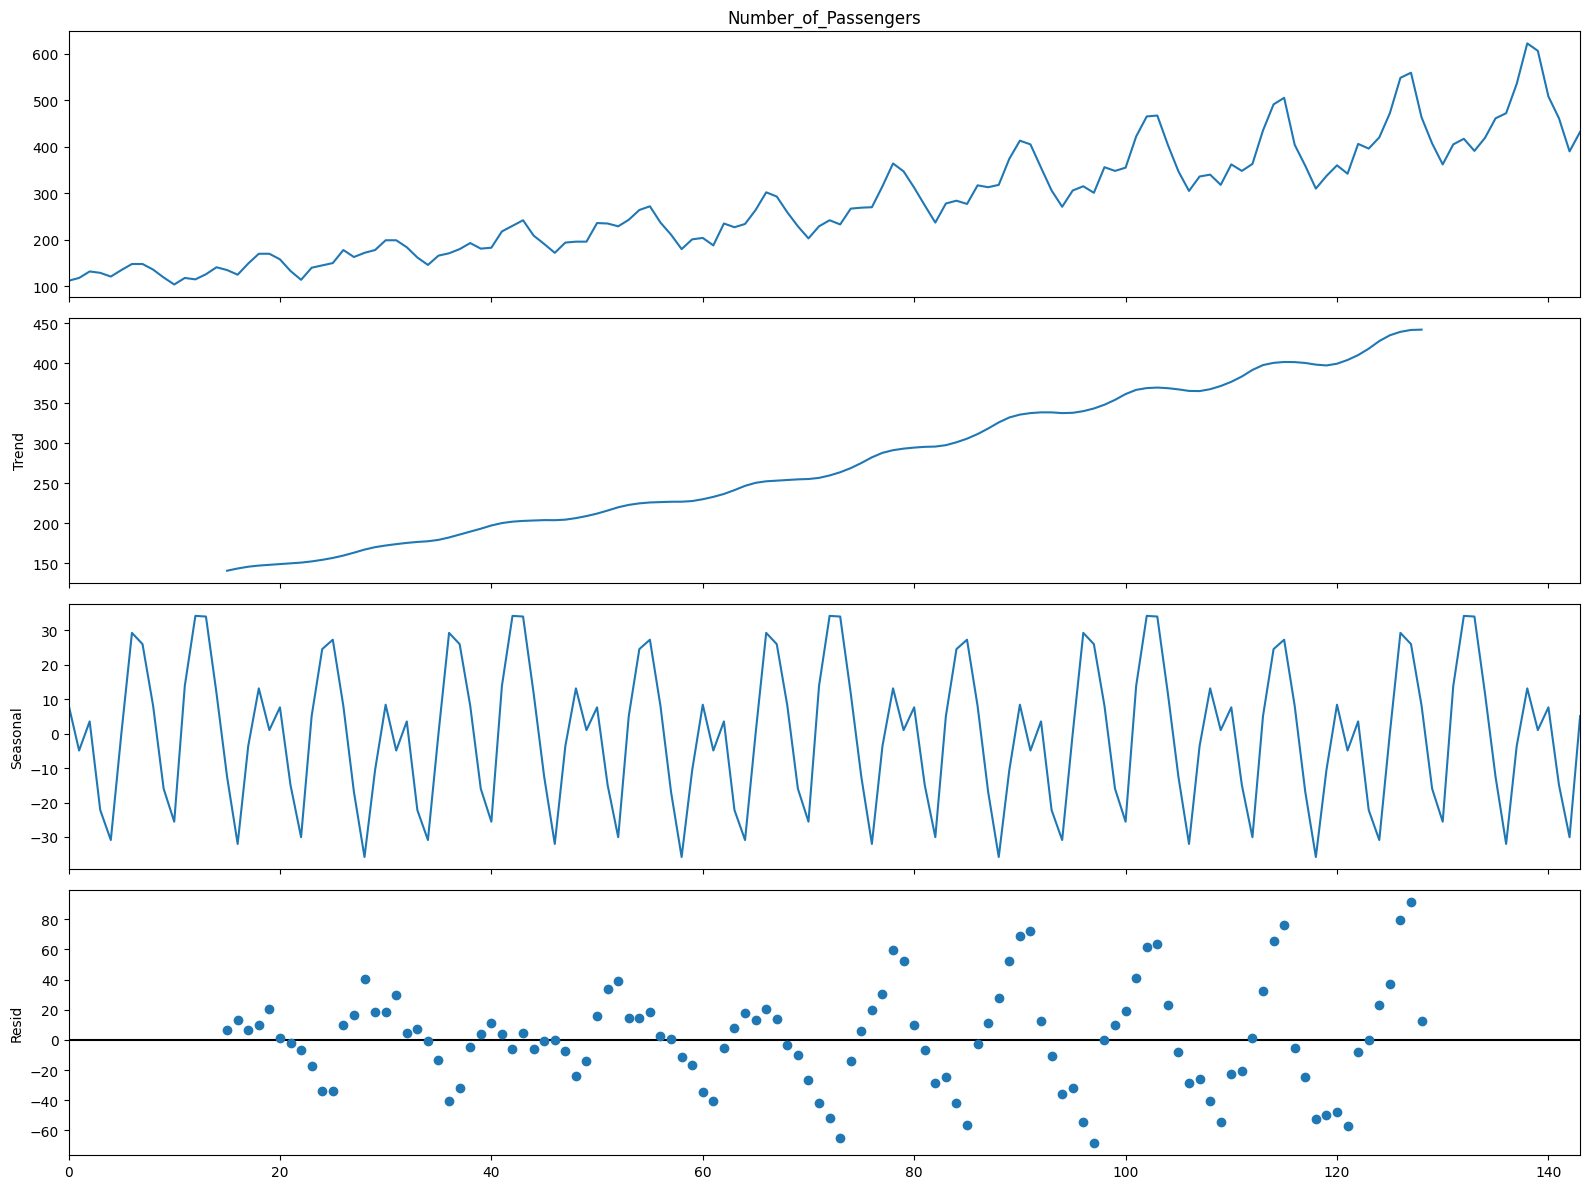

In [212]:
decomposition_plot_add=seasonal_decompose(df['Number_of_Passengers'],model='additive',period=30)
decomposition_plot_add.plot()
plt.show()

### Multiplicative residuals are better as they're more random than the additive resuidulas

## Making the data Stationary



### 1) Differencing

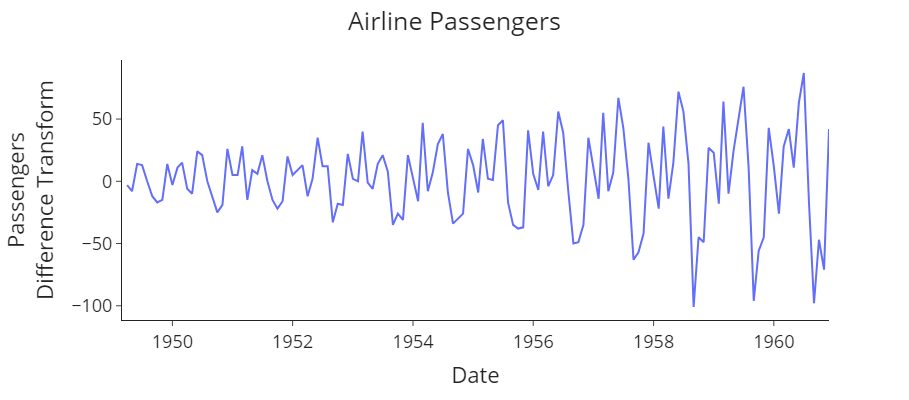

In [543]:
df['Passenger_Diff']=df['Number_of_Passengers'].diff()
plotting(title='Airline Passengers', data=df, x='Date', y='Passenger_Diff',
         x_label='Date', y_label='Passengers<br>Difference Transform')

#### We have get rid of the trend Component

### 2) Box-Cox Transform

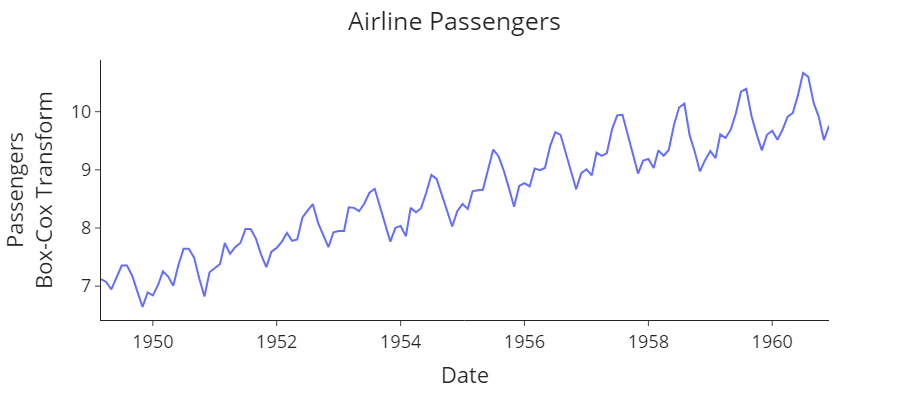

In [547]:
df['Passengers_box_cox'],lam=boxcox(df['Number_of_Passengers'])
plotting(title='Airline Passengers', data=df, x='Date', y='Passengers_box_cox',
         x_label='Date', y_label='Passengers<br>Box-Cox Transform')

### Differencing + Box-Cox Transform aka. STATIONARY DATA

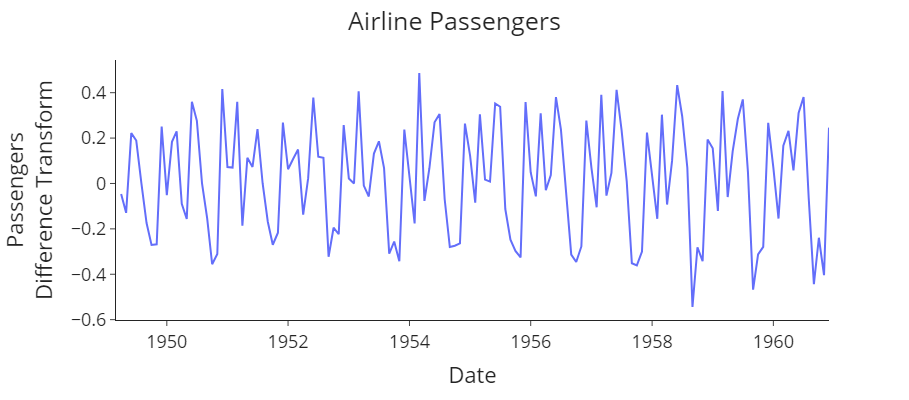

In [550]:
df['Passenger_Diff_box_cox']=df['Passengers_box_cox'].diff()
plotting(title='Airline Passengers', data=df, x='Date', y='Passenger_Diff_box_cox',
         x_label='Date', y_label='Passengers<br>Difference Transform')

### Differencing for the Second time

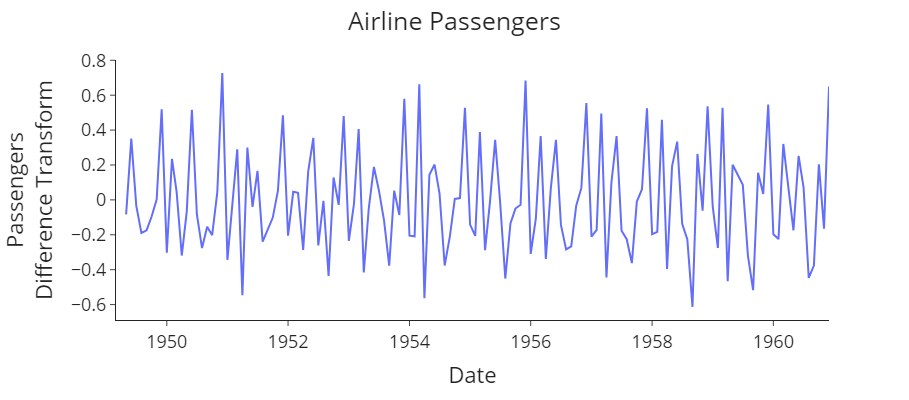

In [553]:
df['Passenger_Diff_Diff_box_cox']=df['Passenger_Diff_box_cox'].diff()
plotting(title='Airline Passengers', data=df, x='Date', y='Passenger_Diff_Diff_box_cox',
         x_label='Date', y_label='Passengers<br>Difference Transform')

### Stationary Test (ADF)

#### One such method is the Augmented Dickey-Fuller (ADF) test. This is a statistical hypothesis test where the null hypothesis is the series is non-stationary (also known as a unit root test).

### 1 Diff Test

In [558]:
def adf_test(series):
    """Using an ADF test to determine if a series is stationary"""
    test_results = adfuller(series)
    print('ADF Statistic: ', test_results[0])
    print('P-Value: ', test_results[1])
    print('Critical Values:')
    for thres, adf_stat in test_results[4].items():
        print('\t%s: %.2f' % (thres, adf_stat))


adf_test(df["Passenger_Diff_box_cox"][1:])

ADF Statistic:  -2.8109003134502544
P-Value:  0.056733526336658374
Critical Values:
	1%: -3.48
	5%: -2.88
	10%: -2.58


### 2 Diff Test

In [561]:
adf_test(df['Passenger_Diff_Diff_box_cox'][2:])

ADF Statistic:  -7.987655220517297
P-Value:  2.5235452700438207e-12
Critical Values:
	1%: -3.48
	5%: -2.88
	10%: -2.58


### This is absloutley not good but to let you know how further differencing can make us almost 99.99999999% sure to reject the null and state that it's SATATIOANRY

## Let's explore some forecasting models or techniques

#### BUT BEFORE WE SHOULD SPLIT THE DATA

In [566]:
train = df.iloc[:-int(len(df) * 0.2)]
test = df.iloc[-int(len(df) * 0.2):]

In [255]:
def plot_func(forecast, title):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train['Date'], y=train['Number_of_Passengers'], name='Train'))
    fig.add_trace(go.Scatter(x=test['Date'], y=forecast, name='Test'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Passenger Volume')
    return fig.show()


### 1) Naive forecast (simply means to take the last model value)

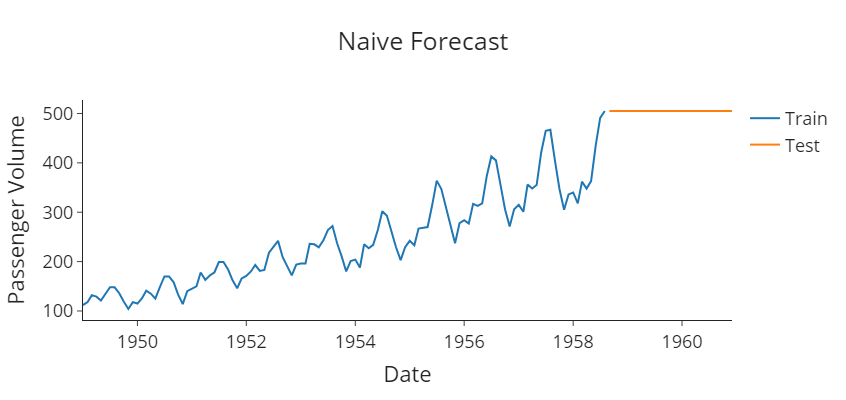

In [257]:
df['naive_forecast']=train['Number_of_Passengers'].iloc[-1]
plot_func(df['naive_forecast'],'Naive Forecast')

### 2) Seasonal Naive Forecasat (simply means immitating the last year season patter)

C:\Users\Moustafa Abdel-sttar\AppData\Local\Temp\ipykernel_3504\3206543703.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\Moustafa Abdel-sttar\AppData\Local\Temp\ipykernel_3504\3206543703.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



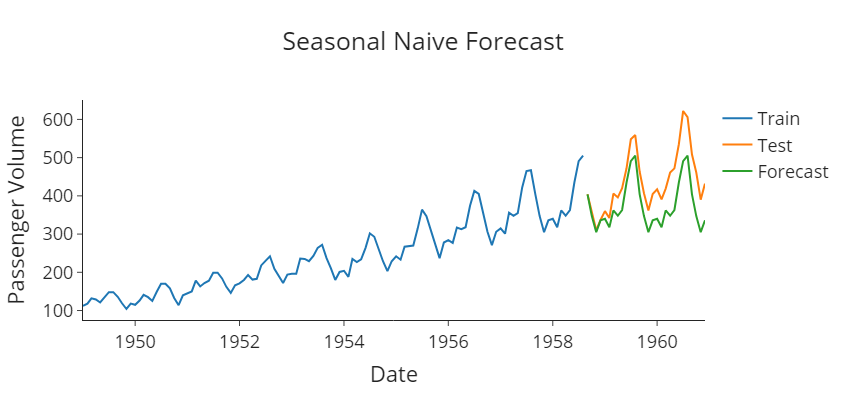

In [297]:
train['month_number'] = pd.DatetimeIndex(train['Date']).month
test['month_number'] = pd.DatetimeIndex(test['Date']).month

snaive_fc = []
for row_idx, row in test.iterrows():
    month = row['month_number']
    forecast = train['Number_of_Passengers'] .loc[train['month_number'] == month].iloc[-1]
    snaive_fc.append(forecast)

plot_func(snaive_fc, 'Seasonal Naive Forecast')

### 3) Simple Exponential Smoothing (Simple: doesn't account for hte trend nor the seasons, put more weights on recent data and less exponentially by time towards the past)

In [399]:
def plot_func(forecasts_simple: list[float],
              title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train['Date'], y=train['Number_of_Passengers'], name='Train'))
    fig.add_trace(go.Scatter(x=test['Date'], y=test['Number_of_Passengers'], name='Test'))
    fig.add_trace(go.Scatter(x=test['Date'], y=forecasts_simple, name='Simple'))
    fig.add_trace(go.Scatter(x=test['Date'], y=forecasts_holt, name='Holt'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Passenger Volume')

    return fig.show()

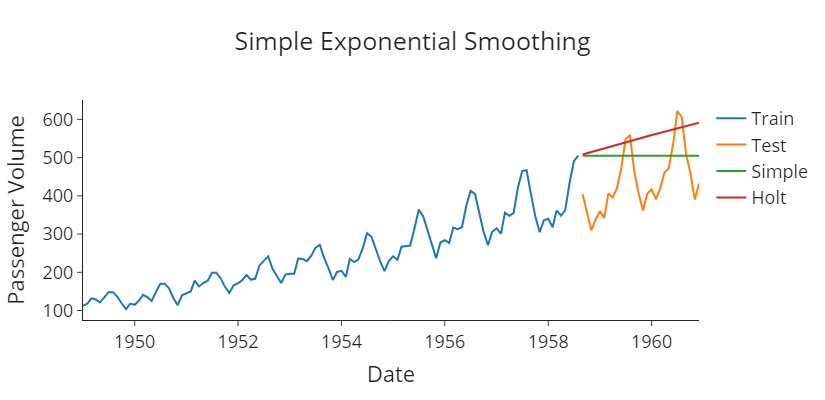

In [401]:
model_simple = SimpleExpSmoothing(train['Number_of_Passengers']).fit(optimized=True)
forecasts_simple = model.forecast(len(test))
plot_func(forecast_simple, 'Simple Exponential Smoothing')

In [403]:
model_simple.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        SimpleExpSmoothing Model Results                        
================================================================================
Dep. Variable:     Number_of_Passengers   No. Observations:                  116
Model:               SimpleExpSmoothing   SSE                          83037.230
Optimized:                         True   AIC                            766.521
Trend:                             None   BIC                            772.028
Seasonal:                          None   AICC                           766.881
Seasonal Periods:                  None   Date:                 Mon, 14 Oct 2024
Box-Cox:                          False   Time:                         23:57:19
Box-Cox Coeff.:                    None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9950000                alpha                 True
initial_level              112.00000                  l.0                False
------------------------------------------------------------------------------
"""

### 4) Holt's Linear Model (aka. Double exponential smoothing which accounts for the trend component)

In [424]:
def plot_func(forecasts_simple: list[float],
              forecasts_holt: list[float],
              title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train['Date'], y=train['Number_of_Passengers'], name='Train'))
    fig.add_trace(go.Scatter(x=test['Date'], y=test['Number_of_Passengers'], name='Test'))
    fig.add_trace(go.Scatter(x=test['Date'], y=forecasts_simple, name='Simple'))
    fig.add_trace(go.Scatter(x=test['Date'], y=forecasts_holt, name='Holt'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Passenger Volume')

    return fig.show()

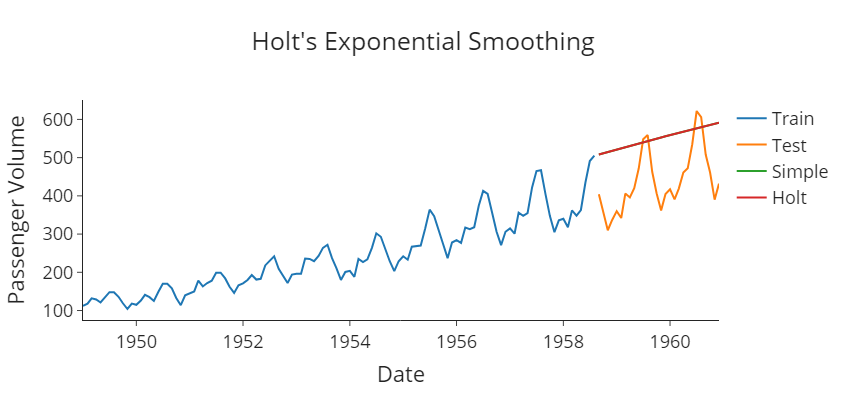

In [426]:
model_holt = Holt(train['Number_of_Passengers'], damped_trend=True).fit(optimized=True)
forecasts_holt = model_holt.forecast(len(test))
plot_func(forecasts_holt, forecasts_holt, "Holt's Exponential Smoothing")

In [414]:
model_holt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               Holt Model Results                               
================================================================================
Dep. Variable:     Number_of_Passengers   No. Observations:                  116
Model:                             Holt   SSE                          82016.805
Optimized:                         True   AIC                            771.086
Trend:                         Additive   BIC                            784.854
Seasonal:                          None   AICC                           772.123
Seasonal Periods:                  None   Date:                 Mon, 14 Oct 2024
Box-Cox:                          False   Time:                         23:58:29
Box-Cox Coeff.:                    None                                         
==============================================================================
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            1.0000000                alpha                 True
smoothing_trend             0.000000                 beta                 True
initial_level              112.00000                  l.0                False
initial_trend              5.9694254                  b.0                False
damping_trend              0.9949042                  phi                 True
------------------------------------------------------------------------------
"""

In [428]:
df.head()

Date  Number_of_Passengers  Passenger_Diff  Passengers_box_cox  \
0 1949-01-01                   112             NaN            6.827490   
1 1949-02-01                   118             6.0            6.932822   
2 1949-03-01                   132            14.0            7.161891   
3 1949-04-01                   129            -3.0            7.114610   
4 1949-05-01                   121            -8.0            6.983786   

   Passenger_Diff_box_cox  Passenger_Diff_Diff_box_cox  naive_forecast  
0                     NaN                          NaN             505  
1                0.105332                          NaN             505  
2                0.229069                     0.123737             505  
3               -0.047281                    -0.276350             505  
4               -0.130824                    -0.083543             505

### 5) Holt's Winters Linear Model (Same as Holt's Linear model + Seasonlity)

In [417]:
def plot_func(forecasts_simple: list[float],
              forecasts_holt: list[float],
              forecasts_holt_winters: list[float],
              title: str) -> None:
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train['Date'], y=train['Number_of_Passengers'], name='Train'))
    fig.add_trace(go.Scatter(x=test['Date'], y=test['Number_of_Passengers'], name='Train'))
    fig.add_trace(go.Scatter(x=test['Date'], y=forecasts_simple, name='Simple'))
    fig.add_trace(go.Scatter(x=test['Date'], y=forecasts_holt, name="Holt's Linear"))
    fig.add_trace(go.Scatter(x=test['Date'], y=forecasts_holt_winters, name='Holt Winters'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=700, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Passenger Volume')
    return fig.show()

C:\Anaconda3\envs\imbalanced_test\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning:

overflow encountered in matmul



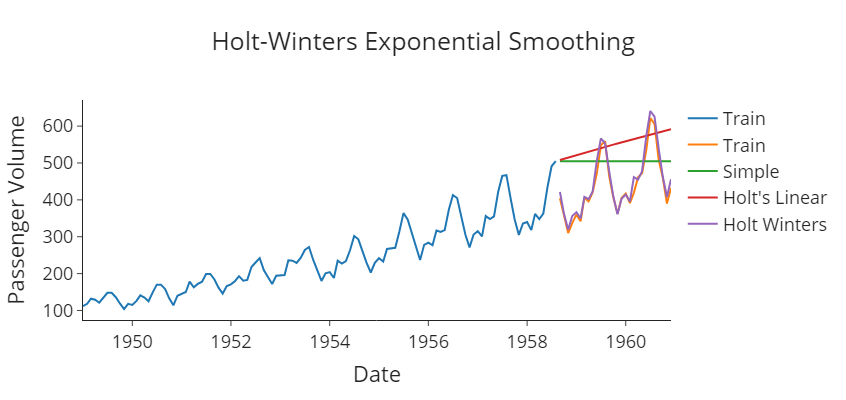

In [419]:
model_holt_winters=ExponentialSmoothing(train['Number_of_Passengers'],trend='mul',seasonal='mul',seasonal_periods=12).fit(optimized=True)
forecasts_holt_winters=model_holt_winters.forecast(len(test))
plot_func(forecasts_simple, forecasts_holt, forecasts_holt_winters,  "Holt-Winters Exponential Smoothing")

In [374]:
model_holt_winters.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       ExponentialSmoothing Model Results                       
================================================================================
Dep. Variable:     Number_of_Passengers   No. Observations:                  116
Model:             ExponentialSmoothing   SSE                          10336.896
Optimized:                         True   AIC                            552.827
Trend:                   Multiplicative   BIC                            596.884
Seasonal:                Multiplicative   AICC                           559.878
Seasonal Periods:                    12   Date:                 Mon, 14 Oct 2024
Box-Cox:                          False   Time:                         23:50:30
Box-Cox Coeff.:                    None                                         
=================================================================================
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3853489                alpha                 True
smoothing_trend                0.000000                 beta                 True
smoothing_seasonal            0.6146511                gamma                 True
initial_level                 112.52083                  l.0                 True
initial_trend                 1.0103084                  b.0                 True
initial_seasons.0             0.9852213                  s.0                 True
initial_seasons.1             1.0395414                  s.1                 True
initial_seasons.2             1.1469229                  s.2                 True
initial_seasons.3             1.0880326                  s.3                 True
initial_seasons.4             1.0001960                  s.4                 True
initial_seasons.5             1.0992690                  s.5                 True
initial_seasons.6             1.2032124                  s.6                 True
initial_seasons.7             1.1891446                  s.7                 True
initial_seasons.8             1.0817516                  s.8                 True
initial_seasons.9             0.9380913                  s.9                 True
initial_seasons.10            0.8311868                 s.10                 True
initial_seasons.11            0.9687038                 s.11                 True
---------------------------------------------------------------------------------
"""

### Some Residuals Analysis 
##### Two basic things we want from that:
    1-No ACF or PACF
    2-Mean=0

#### Does residuals have almost No ACF and PACF?

<Axes: title={'center': 'Residuals'}>

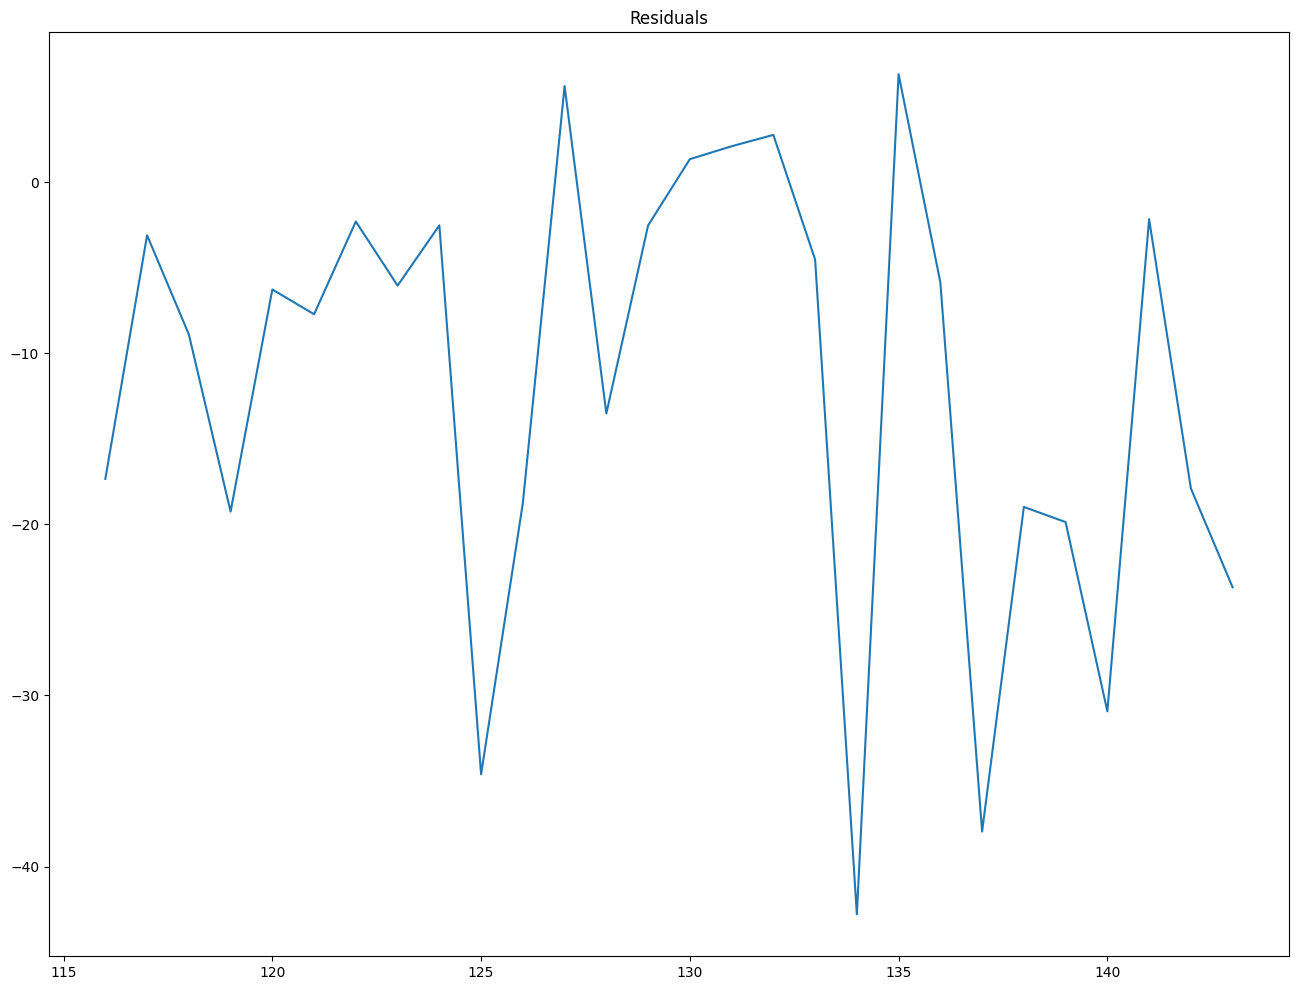

In [441]:
residuals=test['Number_of_Passengers']-forecasts_holt_winters
residuals.plot(title='Residuals')

#### The model captures appearntly all the important data as the residuals seems to be totally RANDOM

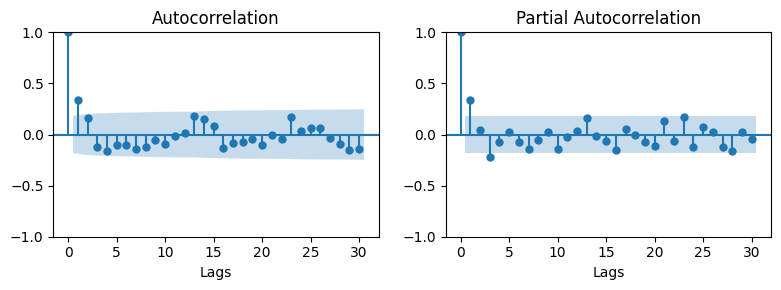

In [471]:
# Plot ACF and PACF
fig, ax = plt.subplots(1,2,figsize=(8,3))
plot_acf(model_holt_winters.resid, lags=30, ax=ax[0])
ax[0].set_xlabel('Lags')
plot_pacf(model_holt_winters.resid, lags=30, ax=ax[1])
ax[1].set_xlabel('Lags')
plt.tight_layout()
plt.show()

##### Most of them are in the non statistical significant region shaded in blue, Which tells us that no correlation between residuals appearntly

#### LBT (Ljung-Box Test) 
##### H_0: Residuals are independently distributed.
##### 
H_1: Residuals are not independently distributed and exhibit serial correlatio




In [460]:
print(acorr_ljungbox(model_holt_winters.resid, return_df=True))


      lb_stat  lb_pvalue
1   13.916933   0.000191
2   16.931521   0.000211
3   18.860757   0.000292
4   22.061111   0.000195
5   23.398157   0.000283
6   24.627424   0.000400
7   27.058899   0.000325
8   29.030774   0.000313
9   29.343881   0.000567
10  30.414507   0.000733


#### p value is less than 5% then we can reject the null hypothsis and say that "No actually the residuals had some info that the model missed and they're not independnt"

#### Does residuals have almost No Mean?

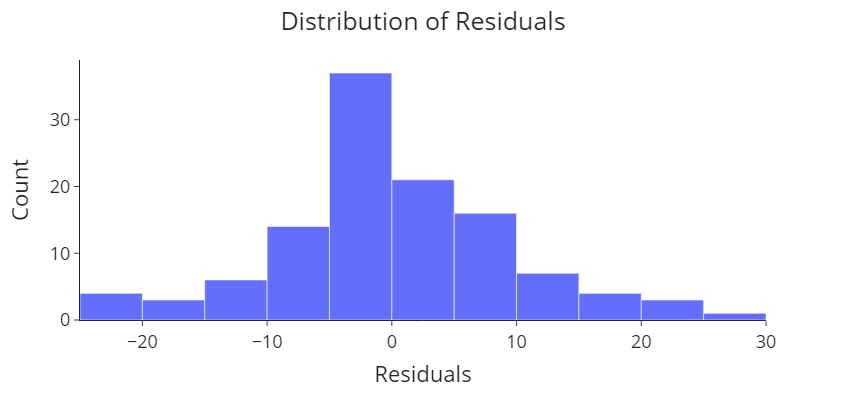

-0.022989707977187822


In [481]:
fig = px.histogram(train, x=model_holt_winters.resid)
fig.update_layout(template="simple_white", font=dict(size=18),
                  title_text='Distribution of Residuals',
                  width=700, title_x=0.5, height=400,
                  xaxis_title='Residuals', yaxis_title='Count')
fig.show()

# Mean of residuals
print(model_holt_winters.resid.mean())

##### BAAAAAAAMMMMM Dude 

#### I will say that residuals are independent, but don't tell the LBT plssssss

### 6) Autoregression model (Linear wighted combination of previous lags)

In [491]:
df

Date  Number_of_Passengers  Passenger_Diff  Passengers_box_cox  \
0   1949-01-01                   112             NaN            6.827490   
1   1949-02-01                   118             6.0            6.932822   
2   1949-03-01                   132            14.0            7.161891   
3   1949-04-01                   129            -3.0            7.114610   
4   1949-05-01                   121            -8.0            6.983786   
..         ...                   ...             ...                 ...   
139 1960-08-01                   606           -16.0           10.684048   
140 1960-09-01                   508           -98.0           10.234572   
141 1960-10-01                   461           -47.0            9.992158   
142 1960-11-01                   390           -71.0            9.582622   
143 1960-12-01                   432            42.0            9.831860   

     Passenger_Diff_box_cox  Passenger_Diff_Diff_box_cox  naive_forecast  
0                       NaN                          NaN             505  
1                  0.105332                          NaN             505  
2                  0.229069                     0.123737             505  
3                 -0.047281                    -0.276350             505  
4                 -0.130824                    -0.083543             505  
..                      ...                          ...             ...  
139               -0.067404                    -0.453545             505  
140               -0.449476                    -0.382072             505  
141               -0.242414                     0.207062             505  
142               -0.409537                    -0.167123             505  
143                0.249238                     0.658774             505  

[144 rows x 7 columns]

##### 6.1) Is your data stationary? yes in the Passenger_Diff_box_cox column of df

##### 6.2) Modeling

In [501]:
df['Passenger_Diff_box_cox']

0           NaN
1      0.105332
2      0.229069
3     -0.047281
4     -0.130824
         ...   
139   -0.067404
140   -0.449476
141   -0.242414
142   -0.409537
143    0.249238
Name: Passenger_Diff_box_cox, Length: 144, dtype: float64

In [503]:
df.dropna(inplace=True)

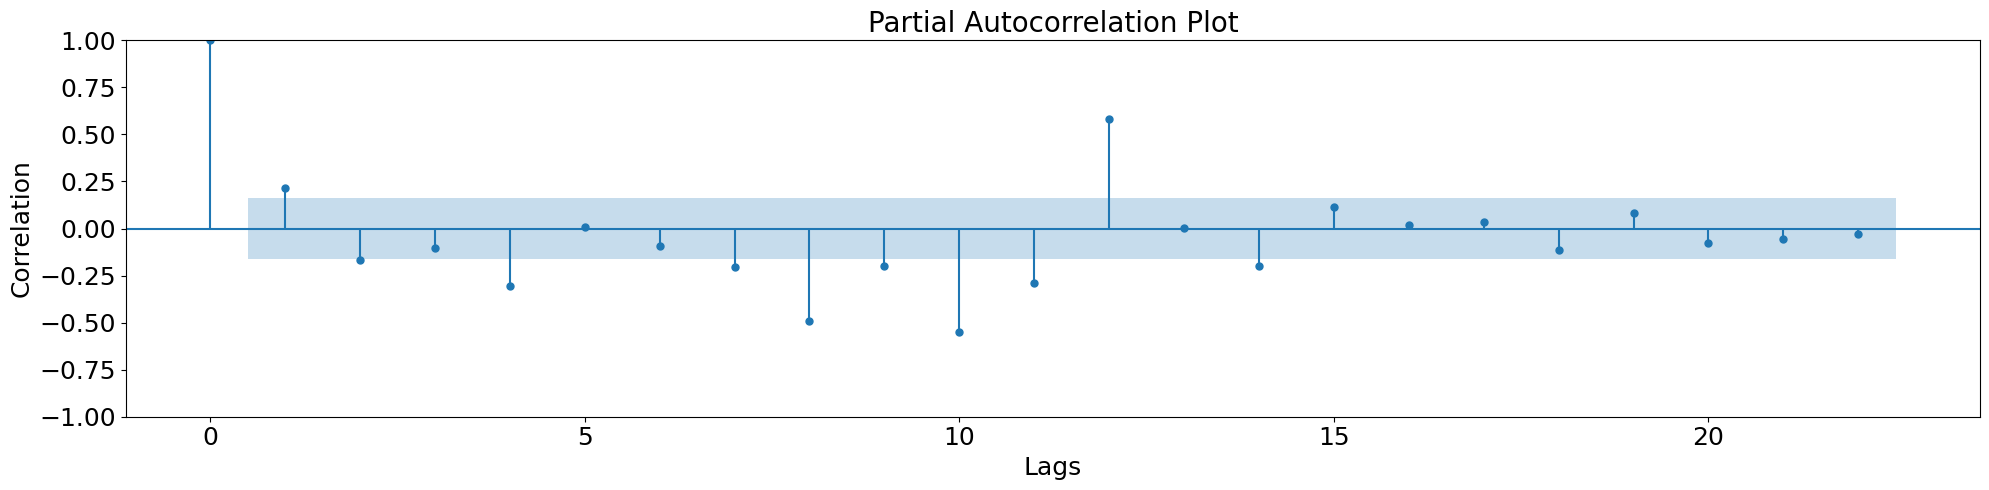

In [505]:
plt.rc("figure", figsize=(20,5))
plot_pacf(df['Passenger_Diff_box_cox'], method='ywm')
plt.xlabel('Lags', fontsize=18)
plt.ylabel('Correlation', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Partial Autocorrelation Plot', fontsize=20)
plt.tight_layout()
plt.show()

In [521]:
selector = ar_select_order(train['Passengers_box_cox'], 20)
selector.ar_lags

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [600]:
train=train.dropna()

In [602]:
model_ar = AutoReg(train['Passenger_Diff_box_cox'], lags=selector.ar_lags).fit()

C:\Anaconda3\envs\imbalanced_test\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.



In [604]:
transformed_forecasts = list(model_ar.forecast(steps=len(test)))
boxcox_forecasts = []
for idx in range(len(test)):
    if idx == 0:
        boxcox_forecast = transformed_forecasts[idx] + train['Passengers_box_cox'].iloc[-1]
    else:
        boxcox_forecast = transformed_forecasts[idx] + boxcox_forecasts[idx-1]

    boxcox_forecasts.append(boxcox_forecast)

forecasts = inv_boxcox(boxcox_forecasts, lam)


C:\Anaconda3\envs\imbalanced_test\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

C:\Anaconda3\envs\imbalanced_test\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



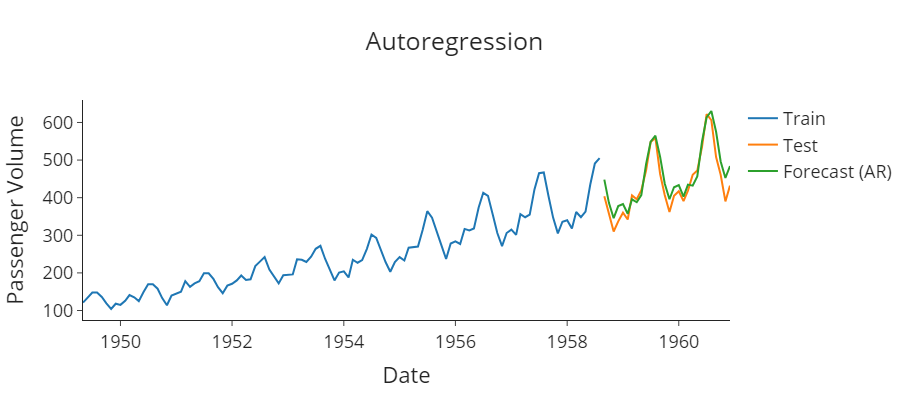

In [606]:
def plot_forecasts(forecasts: list[float],
                   title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train['Date'], y=train['Number_of_Passengers'], name='Train'))
    fig.add_trace(go.Scatter(x=test['Date'], y=test['Number_of_Passengers'], name='Test'))
    fig.add_trace(go.Scatter(x=test['Date'], y=forecasts, name='Forecast (AR)'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Passenger Volume')

    return fig.show()


# Plot the forecasts
plot_forecasts(forecasts, 'Autoregression')

### 7) Moving Average Model  (It's a method that is computed by the mean while modifieying it using weighted errors whether +Ve or -Ve)

In [591]:
df=df.dropna()

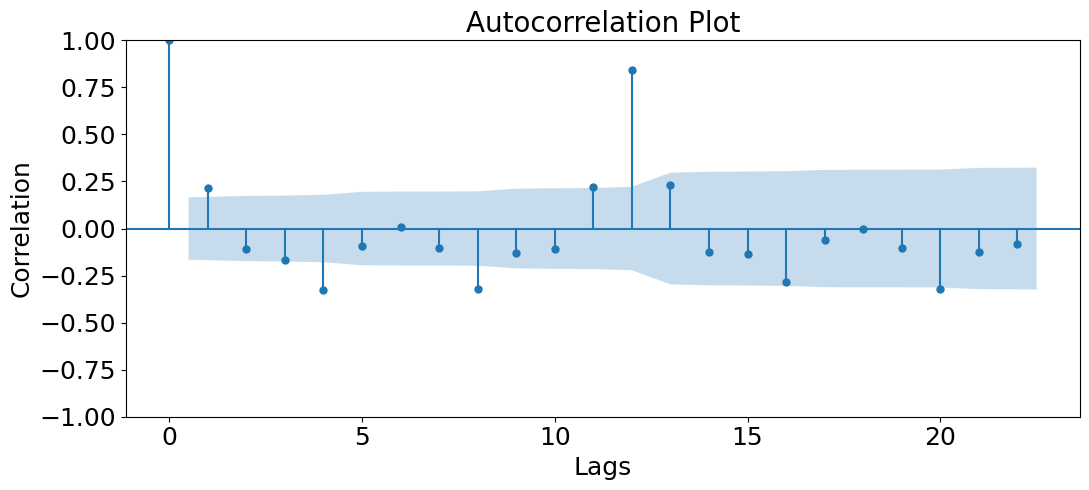

In [593]:
plt.rc("figure", figsize=(11,5))
plot_acf(df['Passenger_Diff_box_cox'])
plt.xlabel('Lags', fontsize=18)
plt.ylabel('Correlation', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.title('Autocorrelation Plot', fontsize=20)
plt.tight_layout()
plt.show()

### As MA isn't implemented it's the same as ARIMA but with setting the p=0 to negate the effect of AR, d=0 because the data is already stationary, q=#lags

In [649]:
train = df.iloc[:-int(len(df) * 0.2)]
test = df.iloc[-int(len(df) * 0.2):]

In [667]:
train.head()

Date  Number_of_Passengers  Passenger_Diff  Passengers_box_cox  \
4 1949-05-01                   121            -8.0            6.943275   
5 1949-06-01                   135            14.0            7.165400   
6 1949-07-01                   148            13.0            7.354684   
7 1949-08-01                   148             0.0            7.354684   
8 1949-09-01                   136           -12.0            7.180501   

   Passenger_Diff_box_cox  Passenger_Diff_Diff_box_cox  naive_forecast  
4               -0.129459                    -0.082676             505  
5                0.222125                     0.351583             505  
6                0.189285                    -0.032840             505  
7                0.000000                    -0.189285             505  
8               -0.174184                    -0.174184             505

In [665]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 112 entries, 4 to 115
Data columns (total 7 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Date                         112 non-null    datetime64[ns]
 1   Number_of_Passengers         112 non-null    int64         
 2   Passenger_Diff               112 non-null    float64       
 3   Passengers_box_cox           112 non-null    float64       
 4   Passenger_Diff_box_cox       112 non-null    float64       
 5   Passenger_Diff_Diff_box_cox  112 non-null    float64       
 6   naive_forecast               112 non-null    int64         
dtypes: datetime64[ns](1), float64(4), int64(2)
memory usage: 7.0 KB


In [722]:
train

Date  Number_of_Passengers  Passengers_Boxcox  Passenger_diff
1   1949-02-01                   118           6.932822        0.105332
2   1949-03-01                   132           7.161891        0.229069
3   1949-04-01                   129           7.114610       -0.047281
4   1949-05-01                   121           6.983786       -0.130824
5   1949-06-01                   135           7.208265        0.224479
..         ...                   ...                ...             ...
111 1958-04-01                   348           9.309365       -0.094067
112 1958-05-01                   363           9.410031        0.100666
113 1958-06-01                   435           9.848860        0.438829
114 1958-07-01                   491          10.149185        0.300325
115 1958-08-01                   505          10.219683        0.070497

[115 rows x 4 columns]

In [724]:
model_ma = ARIMA(train['Passenger_diff'], order=(0, 0, 13)).fit()

C:\Anaconda3\envs\imbalanced_test\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

C:\Anaconda3\envs\imbalanced_test\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

C:\Anaconda3\envs\imbalanced_test\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

C:\Anaconda3\envs\imbalanced_test\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Anaconda3\envs\im

### NEEDS REVISING!!!!

0.1480226277556817


C:\Anaconda3\envs\imbalanced_test\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

C:\Anaconda3\envs\imbalanced_test\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



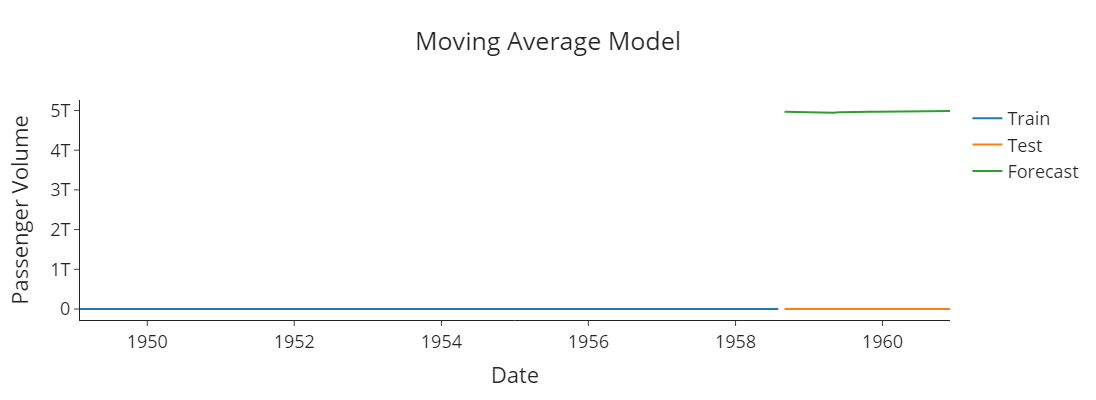

In [726]:
transformed_forecasts = list(model_ma.forecast(steps=len(test)))
boxcox_forecasts = []
for idx in range(len(test)):
    if idx == 0:
        boxcox_forecast = transformed_forecasts[idx] + train['Number_of_Passengers'].iloc[-1]
    else:
        boxcox_forecast = transformed_forecasts[idx] + boxcox_forecasts[idx-1]

    boxcox_forecasts.append(boxcox_forecast)

forecasts = inv_boxcox(boxcox_forecasts, lam)
print(lam)

def plot_forecasts(forecasts: list[float],
                   title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train['Date'], y=train['Number_of_Passengers'], name='Train'))
    fig.add_trace(go.Scatter(x=test['Date'], y=test['Number_of_Passengers'], name='Test'))
    fig.add_trace(go.Scatter(x=test['Date'], y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Passenger Volume')

    return fig.show()


# Plot the forecasts
plot_forecasts(forecasts, 'Moving Average Model')

### 8) ARIMA

In [682]:
df_original

Date  Number_of_Passengers
0   1949-01-01                   112
1   1949-02-01                   118
2   1949-03-01                   132
3   1949-04-01                   129
4   1949-05-01                   121
..         ...                   ...
139 1960-08-01                   606
140 1960-09-01                   508
141 1960-10-01                   461
142 1960-11-01                   390
143 1960-12-01                   432

[144 rows x 2 columns]

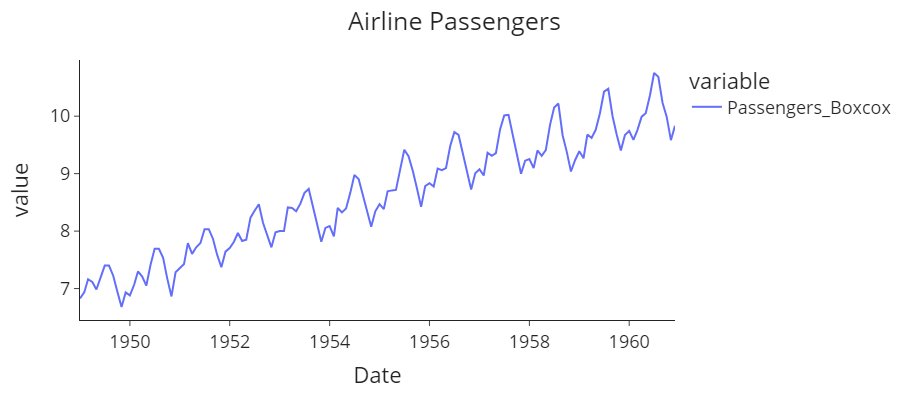

In [684]:
df_original['Passengers_Boxcox'], lam =boxcox(df_original['Number_of_Passengers'])

# Plot the box-cox passenger data
plot_passenger_volumes(df=df_original, y=['Passengers_Boxcox'])

In [696]:
df_original["Passenger_diff"] = df_original["Passengers_Boxcox"].diff()
df_original=df_original.dropna()

In [698]:
df_original

Date  Number_of_Passengers  Passengers_Boxcox  Passenger_diff
1   1949-02-01                   118           6.932822        0.105332
2   1949-03-01                   132           7.161891        0.229069
3   1949-04-01                   129           7.114610       -0.047281
4   1949-05-01                   121           6.983786       -0.130824
5   1949-06-01                   135           7.208265        0.224479
..         ...                   ...                ...             ...
139 1960-08-01                   606          10.684048       -0.067404
140 1960-09-01                   508          10.234572       -0.449476
141 1960-10-01                   461           9.992158       -0.242414
142 1960-11-01                   390           9.582622       -0.409537
143 1960-12-01                   432           9.831860        0.249238

[143 rows x 4 columns]

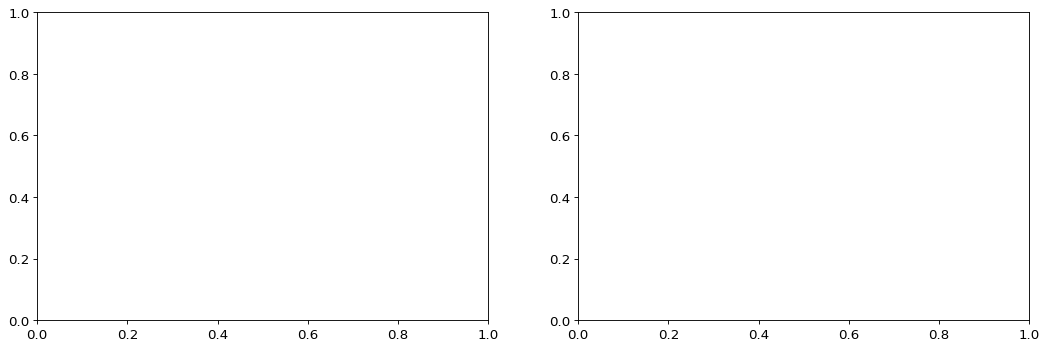

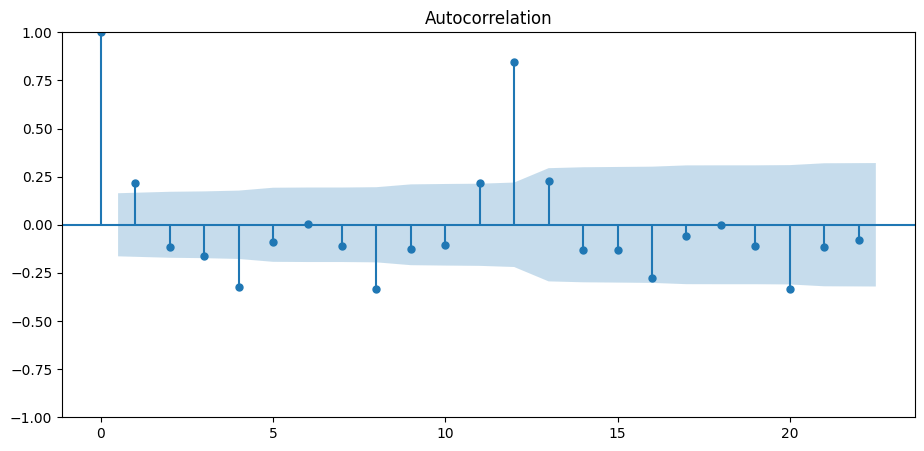

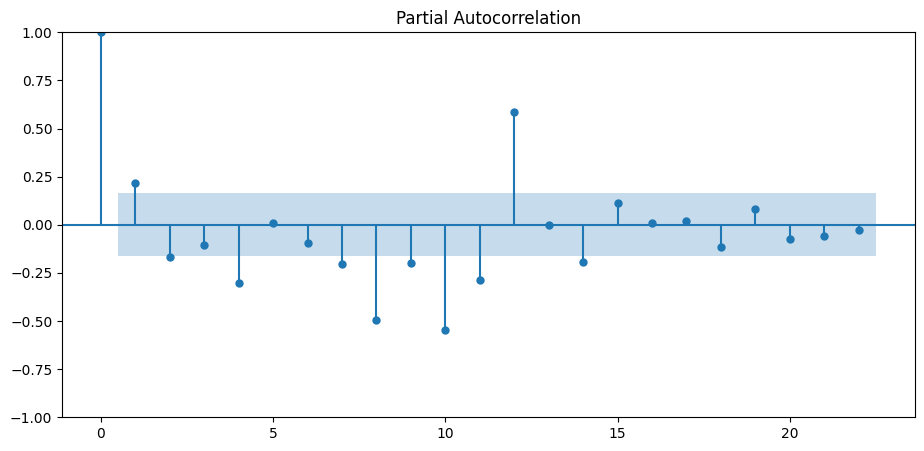

In [700]:
ig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5), dpi=80)
plot_acf(df_original['Passenger_diff'])
plot_pacf(df_original['Passenger_diff'], method='ywm')
ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
plt.show()

In [704]:
train = df_original.iloc[:-int(len(df_original) * 0.2)]
test = df_original.iloc[-int(len(df_original) * 0.2):]

In [706]:
model = ARIMA(train['Passengers_Boxcox'], order=(12, 1, 12)).fit()
boxcox_forecasts = model.forecast(len(test))
forecasts = inv_boxcox(boxcox_forecasts, lam)

C:\Anaconda3\envs\imbalanced_test\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

C:\Anaconda3\envs\imbalanced_test\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

C:\Anaconda3\envs\imbalanced_test\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

C:\Anaconda3\envs\imbalanced_test\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Anaco

In [708]:
df_original

Date  Number_of_Passengers  Passengers_Boxcox  Passenger_diff
1   1949-02-01                   118           6.932822        0.105332
2   1949-03-01                   132           7.161891        0.229069
3   1949-04-01                   129           7.114610       -0.047281
4   1949-05-01                   121           6.983786       -0.130824
5   1949-06-01                   135           7.208265        0.224479
..         ...                   ...                ...             ...
139 1960-08-01                   606          10.684048       -0.067404
140 1960-09-01                   508          10.234572       -0.449476
141 1960-10-01                   461           9.992158       -0.242414
142 1960-11-01                   390           9.582622       -0.409537
143 1960-12-01                   432           9.831860        0.249238

[143 rows x 4 columns]

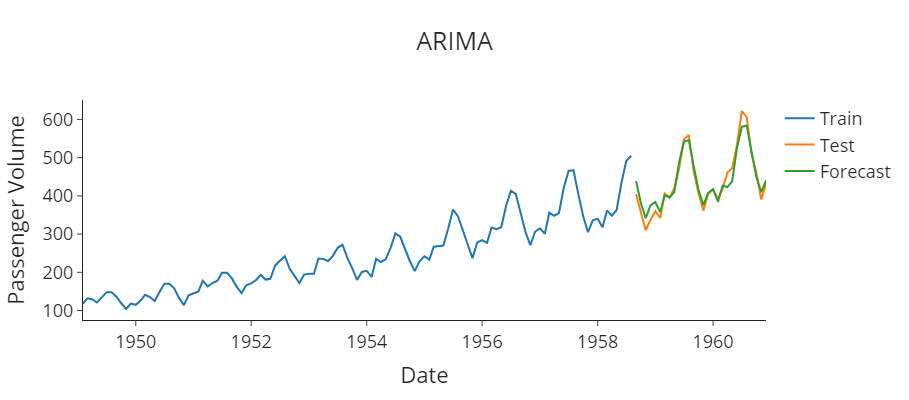

In [710]:
def plot_forecasts(forecasts: list[float], title: str) -> None:
    """Function to plot the forecasts."""
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train['Date'], y=train['Number_of_Passengers'], name='Train'))
    fig.add_trace(go.Scatter(x=test['Date'], y=test['Number_of_Passengers'], name='Test'))
    fig.add_trace(go.Scatter(x=test['Date'], y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Passenger Volume')

    return fig.show()


# Plot the forecasts
plot_forecasts(forecasts, 'ARIMA')

### 9) SARIMA (ARIMA+Seasonality)

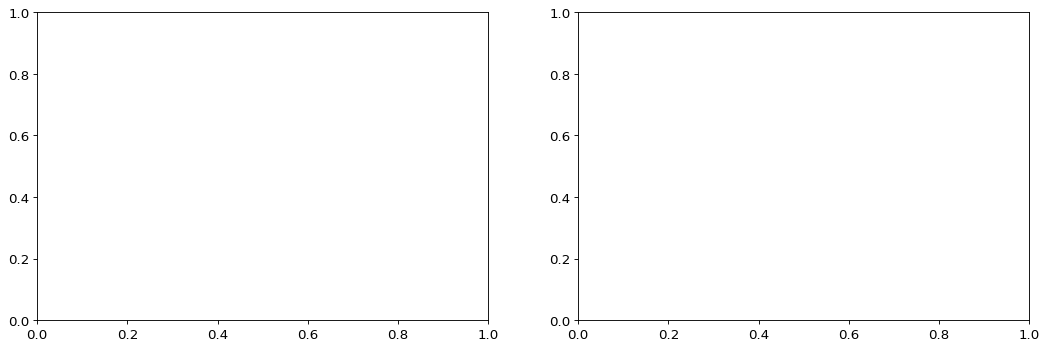

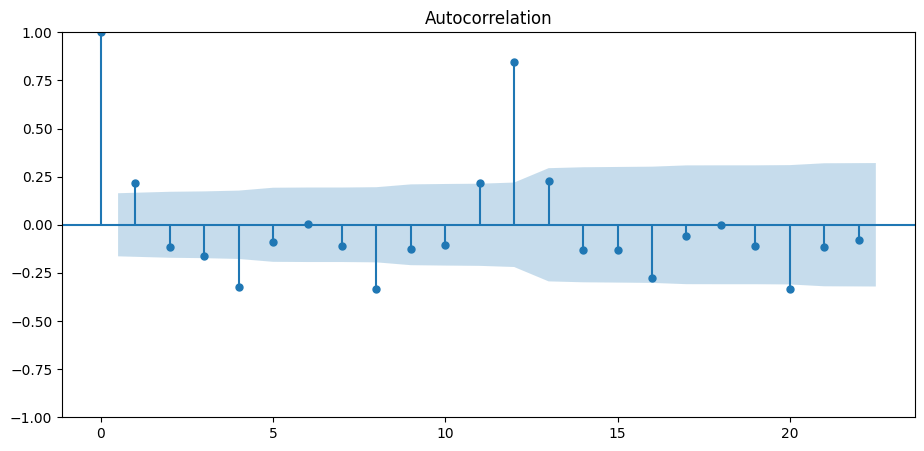

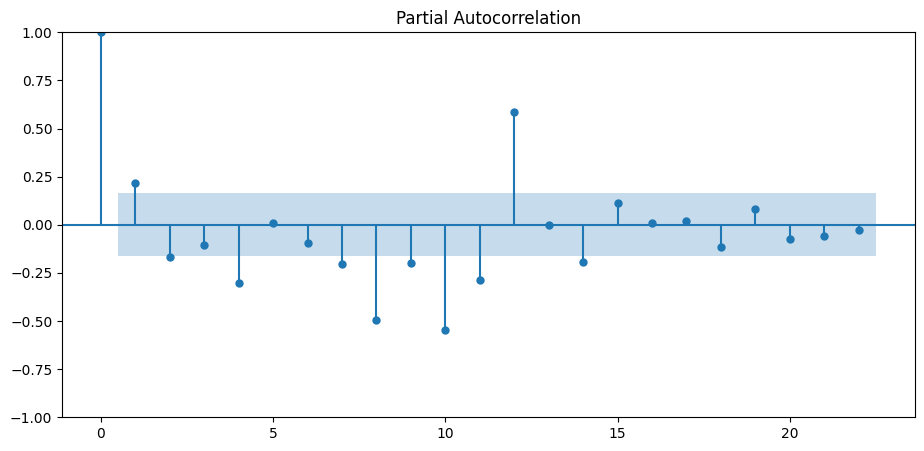

In [716]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5), dpi=80)
plot_acf(df_original['Passenger_diff'])
plot_pacf(df_original['Passenger_diff'], method='ywm')
ax1.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='both', labelsize=12)
plt.show()

In [718]:
model_s = ARIMA(train['Passengers_Boxcox'], order=(10, 1, 10),
              seasonal_order=(1, 1, 1, 12)).fit()
boxcox_forecasts = model_s.forecast(len(test))
forecasts = inv_boxcox(boxcox_forecasts, lam)

C:\Anaconda3\envs\imbalanced_test\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

C:\Anaconda3\envs\imbalanced_test\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

C:\Anaconda3\envs\imbalanced_test\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.

C:\Anaconda3\envs\imbalanced_test\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Anaconda3\envs\im

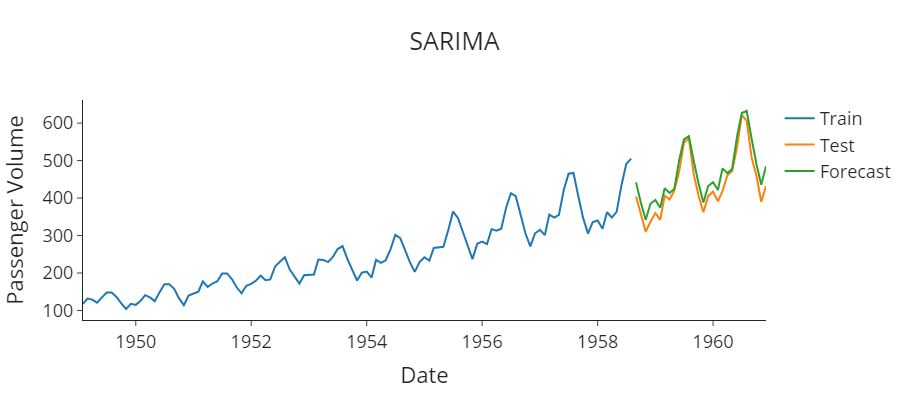

In [720]:
plot_forecasts(forecasts, 'SARIMA')